In [1]:
import cantera as ct
import numpy as np
import csv

# %config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
import matplotlib.pylab as plt

print('running cantera version: ' + ct.__version__)

running cantera version: 3.0.0


In [2]:
gas = ct.Solution("data/chem.yaml")

C:\Users\tahze\AppData\Local\Temp\ipykernel_20124\292288002.py:1: UserWarning: NasaPoly2::validate: 
For species H2, discontinuity in cp/R detected at Tmid = 2.01
	Value computed using low-temperature polynomial:  2.3602934365979036
	Value computed using high-temperature polynomial: 2.9345266806587236

  gas = ct.Solution("data/chem.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_20124\292288002.py:1: UserWarning: NasaPoly2::validate: 
For species H2, discontinuity in h/RT detected at Tmid = 2.01
	Value computed using low-temperature polynomial:  -454.33184031861595
	Value computed using high-temperature polynomial: -401.57655092980355

  gas = ct.Solution("data/chem.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_20124\292288002.py:1: UserWarning: NasaPoly2::validate: 
For species H2, discontinuity in s/R detected at Tmid = 2.01
	Value computed using low-temperature polynomial:  2.335670747304918
	Value computed using high-temperature polynomial: 1.024867759488491

  gas = ct.So

In [3]:
def helper(n):
    gas.TPX = 700, n*ct.one_atm, 'NH3: 1, HCLO4: 1'

    r = ct.IdealGasConstPressureReactor(gas)

    sim = ct.ReactorNet([r])

    # Set the time step
    time_step = 1e-5  # seconds
    time = 0

    max_frp = 0

    dr = []
    temp = []
    t = []
    x_nh3=[]

    while time < 3e-4:
        # forward_rates_of_progress
        # destruction_rates

        t.append(time)
        temp.append(gas.T)

        # molar mass of NH4CLO4 = 117.46
        # density of AP solid = 1.95
        dr.append((gas.destruction_rates[gas.species_index('NH3')] + gas.destruction_rates[gas.species_index('HCLO4')])*1000*117.46*1e-6*(1/1.95)) #g/cm2/s -> cm/s
        x_nh3.append(gas.X[gas.species_index('NH3')])

        time += time_step
        sim.advance(time)
    
    return dr, temp, t, x_nh3

In [4]:
pres = np.arange(1,10,1)
br = []

for n in pres:
    x, temp, _, _ = helper(n)
    dx = np.diff(x)
    dx[0] = 0
    for i, d in enumerate(x):
        if(dx[i] > 0.44):
            print(i)
            br.append(d)
            break

br

18
14
11
10
9
8
7
6
6


[1.376878147451214,
 1.8773426903890338,
 1.7456173957099026,
 2.0843430974759225,
 2.2511681959570526,
 2.296716543232592,
 2.2634059093700674,
 2.181878954076082,
 2.4980503550419986]

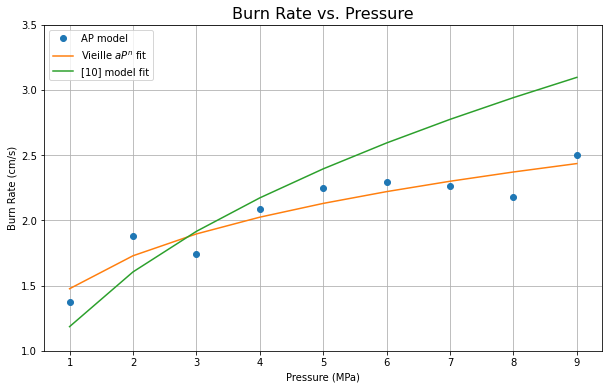

In [5]:
from scipy.optimize import curve_fit

def br_eqn(x, A, N):
    y = A * x**N
    return y

parameters, covariance = curve_fit(br_eqn, pres, br)
fit_y = br_eqn(pres, parameters[0], parameters[1])

def paper(p, A=2.83e-5, N=0.437):
    y = A * p**N
    return y*100

y = []
for i,p in enumerate(pres):
    y.append(paper(p*1e6))


plt.figure(figsize=(10,6))

plt.plot(pres, br, 'o', label = 'AP model')
plt.plot(pres, fit_y, label = r'Vieille $a P^n$ fit')
plt.plot(pres, y, label = '[10] model fit')

plt.xlabel('Pressure (MPa)')
plt.ylabel('Burn Rate (cm/s)')
plt.title('Burn Rate vs. Pressure', fontsize=16)
plt.ylim(1.0, 3.5)
plt.grid()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


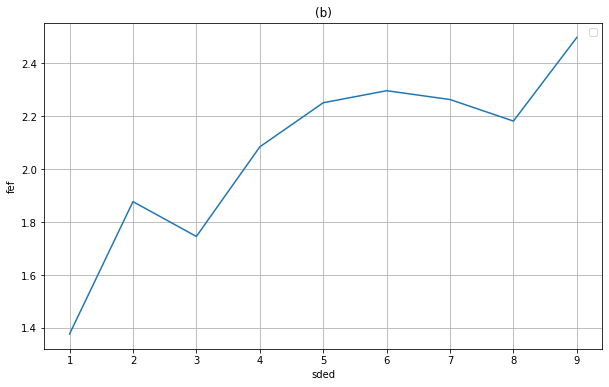

In [6]:
plt.figure(figsize=(10,6))

plt.plot(pres, br)
plt.title('(b)')
plt.xlabel('sded')
plt.ylabel('fef')
plt.grid()
plt.legend()
plt.show()